In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.metrics import Recall, Precision
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
from keras.applications import DenseNet201  
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import SGD
from keras import layers
import multiprocessing

2023-05-10 10:52:06.717635: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-10 10:52:07.316236: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-10 10:52:07.320069: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 10:52:09.390749: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Define the path to the data directory
data_dir = "/media/DATA/tcoil/close_vision"

# Define the paths to the train and test directories
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Define the input image size and number of classes
img_width = 224
img_height = 224
batch_size = 8

In [3]:
def visualize_data(train_dir, val_dir):
    train_counts = []
    val_counts = []
    labels = []

    for folder in os.listdir(train_dir):
        labels.append(folder)
        train_counts.append(len(os.listdir(os.path.join(train_dir, folder))))

    for folder in os.listdir(val_dir):
        val_counts.append(len(os.listdir(os.path.join(val_dir, folder))))

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 8))
    rects1 = ax.bar(x - width/2, train_counts, width, label='Train')
    rects2 = ax.bar(x + width/2, val_counts, width, label='Validation')

    ax.set_ylabel('Number of Images')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()

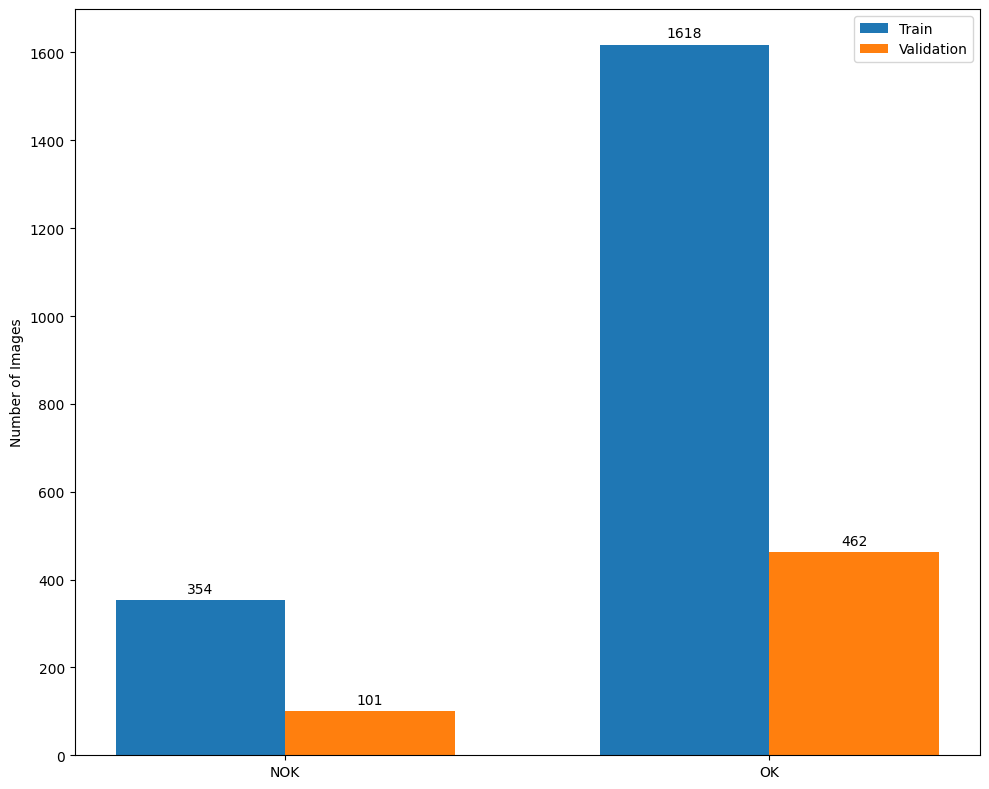

In [4]:
visualize_data(train_dir, val_dir)

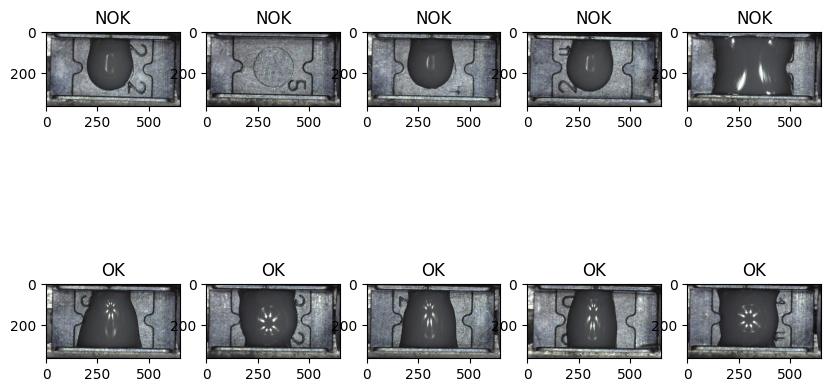

In [5]:
# Define the paths to the train directories for the "fail" and "pass" classes
fail_train_dir = os.path.join(data_dir, "train", "NOK")
pass_train_dir = os.path.join(data_dir, "train", "OK")

# Define the paths to a few images from each class
fail_images = [os.path.join(fail_train_dir, f) for f in os.listdir(fail_train_dir)[:5]]
pass_images = [os.path.join(pass_train_dir, f) for f in os.listdir(pass_train_dir)[:5]]

# Plot the images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 6))

for i, image_path in enumerate(fail_images):
    ax = axes[0, i]
    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title("NOK")

for i, image_path in enumerate(pass_images):
    ax = axes[1, i]
    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title("OK")

plt.show()

In [6]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
    rotation_range=20,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2 
    )

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    seed=42,
    shuffle=True
    )

Found 1972 images belonging to 2 classes.


In [7]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    seed=42,
    shuffle=True
    )

Found 563 images belonging to 2 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    shuffle = False,
    seed=42
    )

Found 283 images belonging to 2 classes.


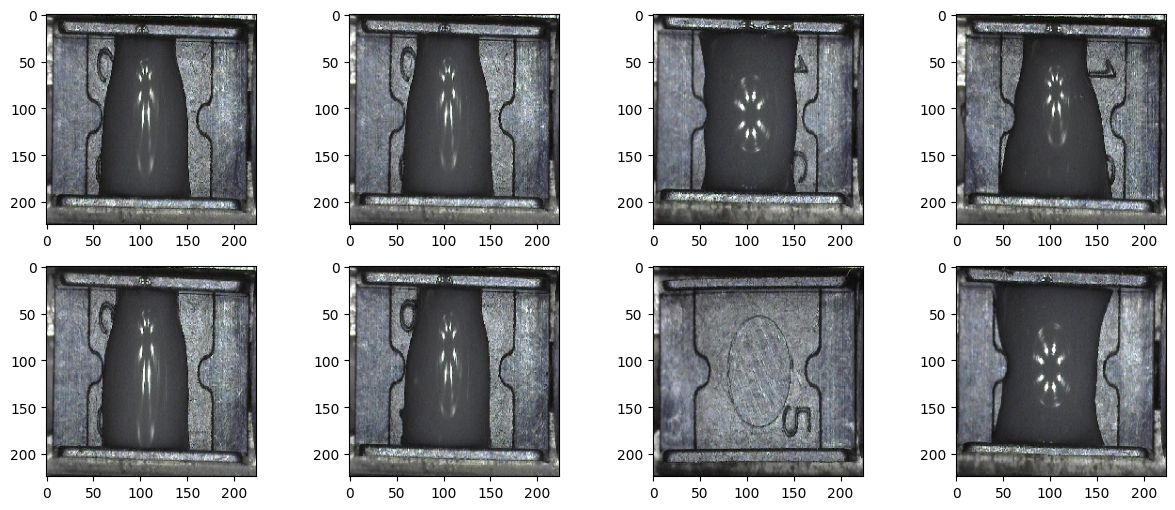

In [9]:
# Get a batch of images from the generator
img_batch, _ = train_data.next()

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(img_batch[i])
    ax.axis('on')
    
plt.show()

In [10]:
class_names = train_data.class_indices
class_names

{'NOK': 0, 'OK': 1}

In [11]:
# Get the class labels from the data generator
labels = train_data.classes

# Calculate the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data.classes), y=labels)

# Convert the class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

In [12]:
class_weight_dict

{0: 2.785310734463277, 1: 0.6093943139678616}

In [13]:
base_model = DenseNet201(
        weights='imagenet', # Load pre-trained weights from the ImageNet dataset
        include_top=False, # Set to False to exclude the top fully connected layers from the model
        input_shape=(img_width, img_height, 3) # The input shape of the images
    )

gmp = GlobalAveragePooling2D()(base_model.output)

output = Dense(1, activation='sigmoid')(gmp)

model = Model(base_model.input, outputs=output)

In [14]:
for layer in base_model.layers:
    layer.trainable = False

In [15]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f0883857fa0>,input_1,False
1,<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f08806327c0>,zero_padding2d,False
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f0880632ca0>,conv1/conv,False
3,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f0880a23b80>,conv1/bn,False
4,<keras.layers.core.activation.Activation object at 0x7f0880632fd0>,conv1/relu,False
...,...,...,...
704,<keras.layers.merging.concatenate.Concatenate object at 0x7f0883802310>,conv5_block32_concat,False
705,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f0883883f70>,bn,False
706,<keras.layers.core.activation.Activation object at 0x7f08837febe0>,relu,False
707,<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f08837ecca0>,global_average_pooling2d,True


In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 14, 14, 1024  4096       ['conv4_block24_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 14, 14, 1024  0          ['conv4_block25_0_bn[0][0]']     
 on)      

 lization)                      )                                                                 
                                                                                                  
 conv4_block29_0_relu (Activati  (None, 14, 14, 1152  0          ['conv4_block29_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 14, 14, 128)  147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block33_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block33_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block33_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block33_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block33_1_relu[0][0]']   
                                                                                                  
 conv4_block33_concat (Concaten  (None, 14, 14, 1312  0          ['conv4_block32_concat[0][0]',   
 ate)                           )                                 'conv4_block33_2_conv[0][0]']   
          

                                                                                                  
 conv4_block37_concat (Concaten  (None, 14, 14, 1440  0          ['conv4_block36_concat[0][0]',   
 ate)                           )                                 'conv4_block37_2_conv[0][0]']   
                                                                                                  
 conv4_block38_0_bn (BatchNorma  (None, 14, 14, 1440  5760       ['conv4_block37_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block38_0_relu (Activati  (None, 14, 14, 1440  0          ['conv4_block38_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_blo

 conv4_block42_0_relu (Activati  (None, 14, 14, 1568  0          ['conv4_block42_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block42_1_conv (Conv2D)  (None, 14, 14, 128)  200704      ['conv4_block42_0_relu[0][0]']   
                                                                                                  
 conv4_block42_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block42_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block42_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block42_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block46_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block46_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block46_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block46_1_relu[0][0]']   
                                                                                                  
 conv4_block46_concat (Concaten  (None, 14, 14, 1728  0          ['conv4_block45_concat[0][0]',   
 ate)                           )                                 'conv4_block46_2_conv[0][0]']   
                                                                                                  
 conv4_block47_0_bn (BatchNorma  (None, 14, 14, 1728  6912       ['conv4_block46_concat[0][0]']   
 lization)

                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 128)   512         ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_concat (Concatena  (None, 7, 7, 960)   0           ['conv5_block1_concat[0][0]',    
 te)      

 conv5_block6_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block6_1_relu[0][0]']    
                                                                                                  
 conv5_block6_concat (Concatena  (None, 7, 7, 1088)  0           ['conv5_block5_concat[0][0]',    
 te)                                                              'conv5_block6_2_conv[0][0]']    
                                                                                                  
 conv5_block7_0_bn (BatchNormal  (None, 7, 7, 1088)  4352        ['conv5_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block7_0_relu (Activatio  (None, 7, 7, 1088)  0           ['conv5_block7_0_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block11_0_relu (Activati  (None, 7, 7, 1216)  0           ['conv5_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_1_conv (Conv2D)  (None, 7, 7, 128)    155648      ['conv5_block11_0_relu[0][0]']   
                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block11_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block11_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block15_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block15_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block15_1_relu[0][0]']   
                                                                                                  
 conv5_block15_concat (Concaten  (None, 7, 7, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)                                                             'conv5_block15_2_conv[0][0]']   
                                                                                                  
 conv5_blo

 conv5_block19_concat (Concaten  (None, 7, 7, 1504)  0           ['conv5_block18_concat[0][0]',   
 ate)                                                             'conv5_block19_2_conv[0][0]']   
                                                                                                  
 conv5_block20_0_bn (BatchNorma  (None, 7, 7, 1504)  6016        ['conv5_block19_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block20_0_relu (Activati  (None, 7, 7, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block20_1_conv (Conv2D)  (None, 7, 7, 128)    192512      ['conv5_block20_0_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv5_block24_1_conv (Conv2D)  (None, 7, 7, 128)    208896      ['conv5_block24_0_relu[0][0]']   
                                                                                                  
 conv5_block24_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block24_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block24_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

 conv5_block28_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block28_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block28_1_relu[0][0]']   
                                                                                                  
 conv5_block28_concat (Concaten  (None, 7, 7, 1792)  0           ['conv5_block27_concat[0][0]',   
 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_block29_0_bn (BatchNorma  (None, 7, 7, 1792)  7168        ['conv5_block28_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 bn (BatchNormalization)        (None, 7, 7, 1920)   7680        ['conv5_block32_concat[0][0]']   
                                                                                                  
 relu (Activation)              (None, 7, 7, 1920)   0           ['bn[0][0]']                     
                                                                                                  
 global_average_pooling2d (Glob  (None, 1920)        0           ['relu[0][0]']                   
 alAveragePooling2D)                                                                              
                                                                                                  
 dense (Dense)                  (None, 1)            1921        ['global_average_pooling2d[0][0]'
                                                                 ]                                
          

In [17]:
recall = Recall()
precision = Precision()

In [18]:
optimizer = SGD(learning_rate=0.01, decay=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy', recall, precision])

In [19]:
early_stopping_cb = EarlyStopping(patience=3,
                                  restore_best_weights=True,
                                  monitor='val_loss',
                                  mode='min')

In [20]:
EPOCHS = 10

num_workers = multiprocessing.cpu_count()
#workers=num_workers,
#use_multiprocessing=True,
#class_weight=class_weight_dict
history = model.fit(train_data, 
                      validation_data=val_data,
                      epochs=EPOCHS,
                      steps_per_epoch=(train_data.n//batch_size),
                      validation_steps=(val_data.n//batch_size),
                      callbacks=[early_stopping_cb],
                      class_weight=class_weight_dict
                  )

Epoch 1/10


2023-05-10 10:52:38.131053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


123/123 [==============================] - ETA: 0s - loss: 0.1390 - accuracy: 0.9463 - recall: 0.9469 - precision: 0.9870

2023-05-10 10:55:13.508437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


123/123 [==============================] - 199s 2s/step - loss: 0.1390 - accuracy: 0.9463 - recall: 0.9469 - precision: 0.9870 - val_loss: 0.0302 - val_accuracy: 0.9911 - val_recall: 0.9891 - val_precision: 1.0000
Epoch 2/10
123/123 [==============================] - 180s 1s/step - loss: 0.0405 - accuracy: 0.9923 - recall: 0.9925 - precision: 0.9981 - val_loss: 0.0584 - val_accuracy: 0.9804 - val_recall: 0.9761 - val_precision: 1.0000
Epoch 3/10
123/123 [==============================] - 179s 1s/step - loss: 0.0355 - accuracy: 0.9893 - recall: 0.9881 - precision: 0.9987 - val_loss: 0.0317 - val_accuracy: 0.9911 - val_recall: 0.9892 - val_precision: 1.0000
Epoch 4/10
123/123 [==============================] - 181s 1s/step - loss: 0.0274 - accuracy: 0.9944 - recall: 0.9938 - precision: 0.9994 - val_loss: 0.0316 - val_accuracy: 0.9911 - val_recall: 0.9891 - val_precision: 1.0000


In [21]:
len(base_model.layers)

707

In [22]:
for layer in base_model.layers:
  layer.trainable = True

In [23]:
optimizer = SGD(learning_rate=0.001, decay=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy', recall, precision])

In [24]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
df = pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 
df 

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f0883857fa0>,input_1,True
1,<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f08806327c0>,zero_padding2d,True
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f0880632ca0>,conv1/conv,True
3,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f0880a23b80>,conv1/bn,True
4,<keras.layers.core.activation.Activation object at 0x7f0880632fd0>,conv1/relu,True
...,...,...,...
704,<keras.layers.merging.concatenate.Concatenate object at 0x7f0883802310>,conv5_block32_concat,True
705,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f0883883f70>,bn,True
706,<keras.layers.core.activation.Activation object at 0x7f08837febe0>,relu,True
707,<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f08837ecca0>,global_average_pooling2d,True


In [25]:
df['Layer Trainable'].value_counts()[True]

709

In [26]:
early_stopping_cb = EarlyStopping(patience=10,
                                  restore_best_weights=True,
                                  monitor='val_loss',
                                  mode='min')

In [27]:
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [28]:
checkpoint_cb = ModelCheckpoint('model_1.h5',
                                save_best_only=True,
                                monitor='val_loss',
                                mode='min')

In [29]:
EPOCHS = 100

num_workers = multiprocessing.cpu_count()

history = model.fit(train_data, 
                      validation_data=val_data,
                      epochs=EPOCHS,
                      steps_per_epoch=(train_data.n//batch_size),
                      validation_steps=(val_data.n//batch_size),
                      callbacks=[early_stopping_cb,checkpoint_cb, reduce_lr_cb],
                      class_weight=class_weight_dict
                   )

Epoch 1/100


2023-05-10 11:04:58.922430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


123/123 [==============================] - ETA: 0s - loss: 0.0898 - accuracy: 0.9565 - recall: 0.9583 - precision: 0.9980

2023-05-10 11:19:08.612223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


123/123 [==============================] - 896s 7s/step - loss: 0.0898 - accuracy: 0.9565 - recall: 0.9583 - precision: 0.9980 - val_loss: 0.0228 - val_accuracy: 0.9982 - val_recall: 0.9978 - val_precision: 1.0000 - lr: 0.0010
Epoch 2/100
123/123 [==============================] - 871s 7s/step - loss: 0.0074 - accuracy: 0.9980 - recall: 0.9975 - precision: 1.0000 - val_loss: 0.0151 - val_accuracy: 0.9982 - val_recall: 0.9978 - val_precision: 1.0000 - lr: 0.0010
Epoch 3/100
123/123 [==============================] - 859s 7s/step - loss: 0.0036 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0104 - val_accuracy: 0.9982 - val_recall: 0.9978 - val_precision: 1.0000 - lr: 0.0010
Epoch 4/100
123/123 [==============================] - 863s 7s/step - loss: 0.0119 - accuracy: 0.9985 - recall: 0.9988 - precision: 0.9994 - val_loss: 0.0279 - val_accuracy: 0.9964 - val_recall: 0.9956 - val_precision: 1.0000 - lr: 0.0010
Epoch 5/100
123/123 [==============================] - 8

In [30]:
def visualize_training_results(results):
    history = results.history
    
    # Find the epoch where validation accuracy was highest
    best_epoch = np.argmin(history['val_loss'])
    
    for m in ['loss', 'accuracy', 'precision', 'recall']:
        plt.figure(figsize=(15,5))
        plt.plot(history[m], label='Training', marker='o', color='blue')
        plt.plot(history[f'val_{m}'], label='Validation', marker='o', color='red')
        plt.axvline(x=best_epoch, linestyle='--', color='green', label='Best epoch')
        plt.xlabel('Epochs')
        plt.legend()
        plt.title(m.title())
    
    plt.show()

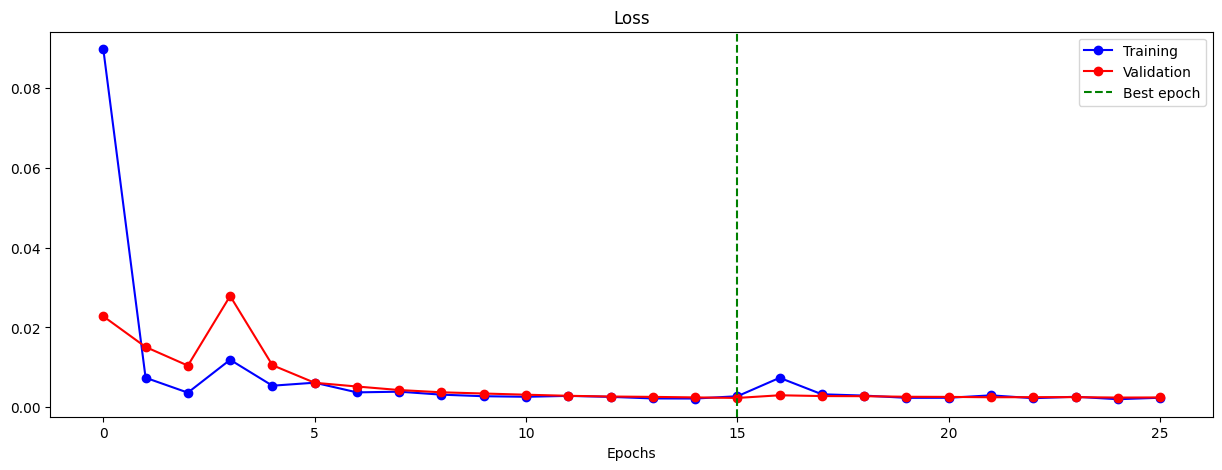

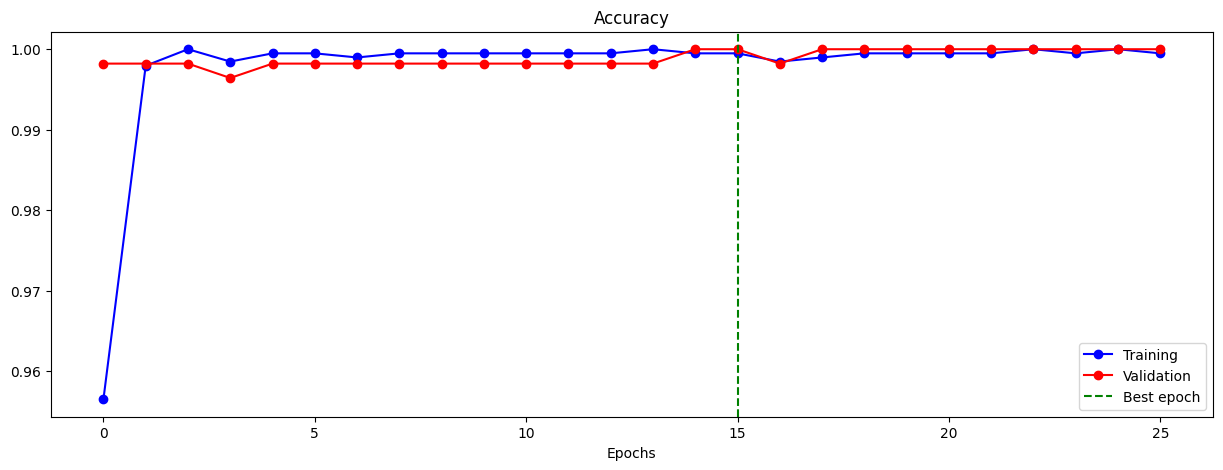

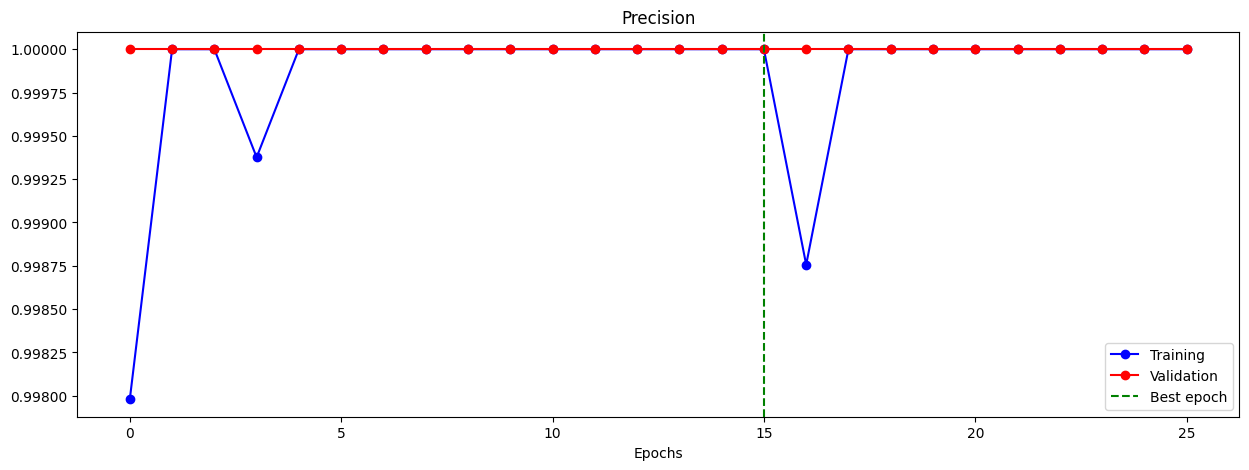

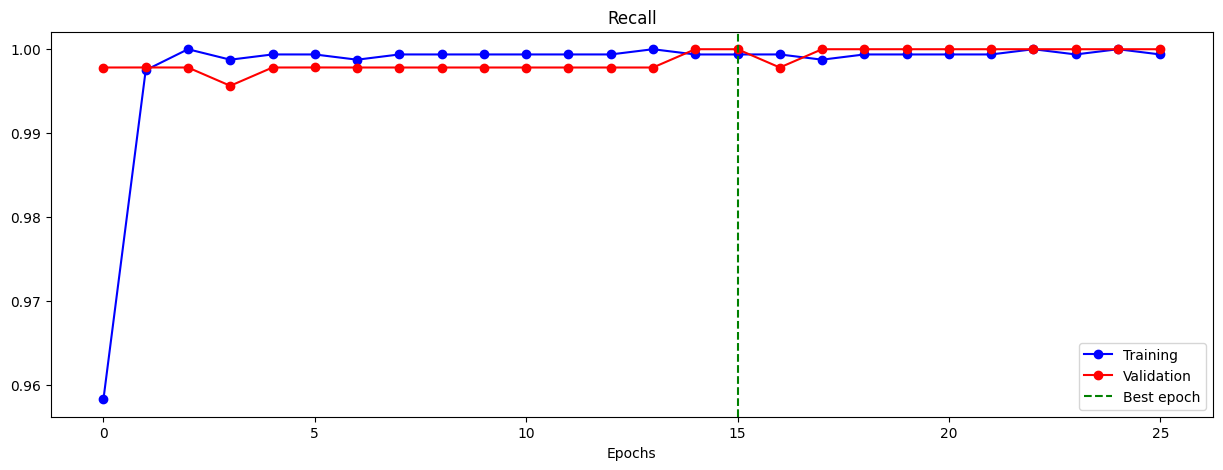

In [31]:
visualize_training_results(history)

In [32]:
def plot_metrics(model, test_data):
    # Get the predicted labels and true labels
    y_pred = model.predict(test_data)
    y_pred = y_pred > 0.5
    y_true = test_data.labels

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax1)
    ax1.set_xlabel('Predicted labels')
    ax1.set_ylabel('True labels')
    ax1.set_title('Confusion Matrix')
    ax1.xaxis.set_ticklabels(['NO OK', 'OK'])
    ax1.yaxis.set_ticklabels(['NO OK', 'OK'])

    # Calculate the true positive rate (TPR) and false positive rate (FPR) at different thresholds
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # Calculate the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    ax2.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    ax2.plot([0, 1], [0, 1], linestyle='--', label='Random guessing')
    
    ax2.set_xlabel('False Positive Rate (FPR)')
    ax2.set_ylabel('True Positive Rate (TPR)')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax2.legend(loc="lower right")

    plt.show()
    
    # Generate the classification report
    report = classification_report(y_true, y_pred)
    # Print the report
    print(report)


2023-05-10 17:49:25.928102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


18/18 [==============================] - 26s 1s/step


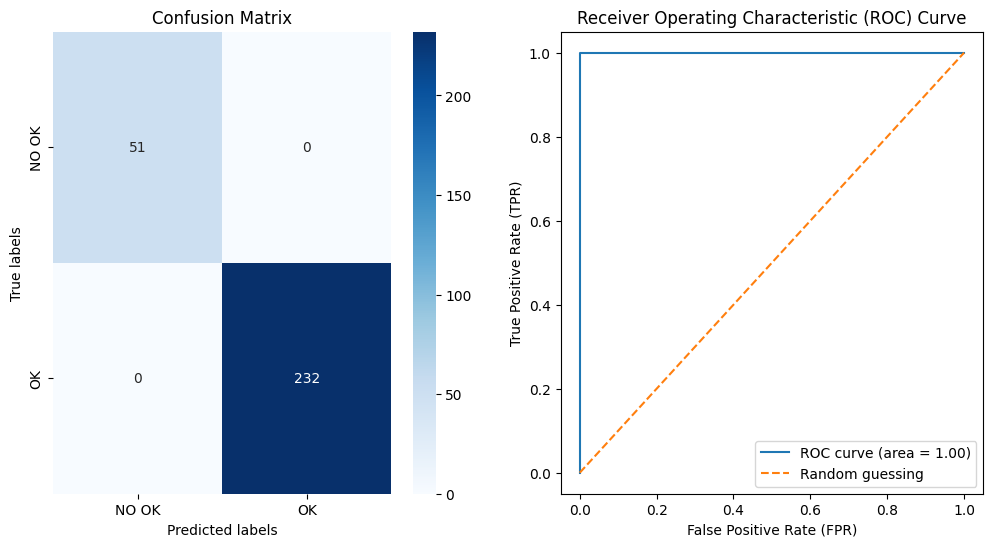

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       1.00      1.00      1.00       232

    accuracy                           1.00       283
   macro avg       1.00      1.00      1.00       283
weighted avg       1.00      1.00      1.00       283



In [33]:
plot_metrics(model, test_data)

In [34]:
# Print the metrics of the best epoch
best_epoch = np.argmin(history.history['val_loss'])
print("Best epoch: ", best_epoch)
print("Best loss: ", history.history['loss'][best_epoch])
print("Best accuracy: ", history.history['accuracy'][best_epoch])
print("Best recall: ", history.history['recall'][best_epoch])
print("Best precision: ", history.history['precision'][best_epoch])
print("Best val_loss: ", history.history['val_loss'][best_epoch])
print("Best val_accuracy: ", history.history['val_accuracy'][best_epoch])
print("Best val_recall: ", history.history['val_recall'][best_epoch])
print("Best val_precision: ", history.history['val_precision'][best_epoch])

Best epoch:  15
Best loss:  0.0027200356125831604
Best accuracy:  0.9994887709617615
Best recall:  0.9993757605552673
Best precision:  1.0
Best val_loss:  0.002292693592607975
Best val_accuracy:  1.0
Best val_recall:  1.0
Best val_precision:  1.0


In [ ]:
from keras.models import load_model
saved_model = load_model('model_1.h5')
plot_metrics(saved_model,test_data)